<a href="https://colab.research.google.com/github/kaushikRajGhimire/Data-Science-Masters-Certification/blob/main/PAPER.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# importing required Libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score,accuracy_score,recall_score
from sklearn.metrics import roc_curve
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures


In [ ]:
df=pd.read_csv('/content/modified_creditcard_dataset (1).csv')

<Axes: >

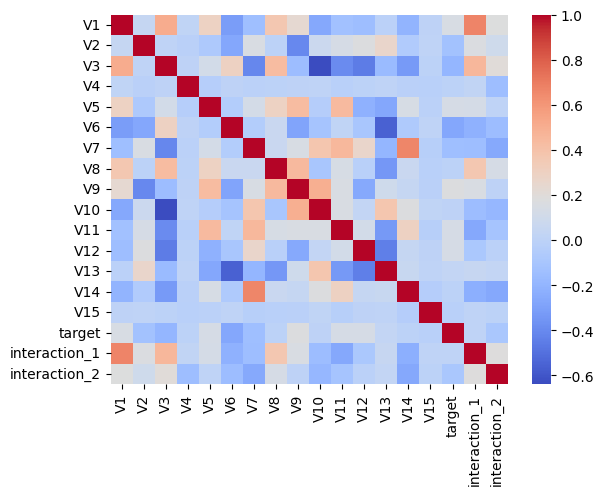

In [ ]:
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, cmap='coolwarm', annot=False)


In [ ]:
upper = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]
df = df.drop(columns=to_drop)


In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X = df.drop('target', axis=1)
y = df['target']

X_scaled = scaler.fit_transform(X)


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, stratify=y, random_state=42
)


In [ ]:
!pip install torch

In [ ]:
import torch
torch.cuda.is_available()


False

In [ ]:
# Install the necessary libraries
!pip install imbalanced-learn xgboost ctgan torch



Found existing installation: ctgan 0.10.2
Uninstalling ctgan-0.10.2:
  Successfully uninstalled ctgan-0.10.2


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KernelDensity
from sklearn.utils import shuffle
from xgboost import XGBClassifier
from scipy.stats import randint, uniform

# Load dataset
data = pd.read_csv('/content/modified_creditcard_dataset (1).csv')

# Split the data into features and target
X = data.drop(columns=['target'])
y = data['target']

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, random_state=42, stratify=y
)

# Separate minority data
X_train_minority = X_train[y_train == 1]

# Simulate synthetic data generation using KDE
kde = KernelDensity(kernel='gaussian', bandwidth=0.7).fit(X_train_minority)
synthetic_minority_samples = kde.sample(n_samples=(3 * (len(X_train[y_train == 0]) - len(X_train_minority))))

# Combine original and synthetic data
X_train_balanced = np.vstack((X_train, synthetic_minority_samples))
y_train_balanced = np.hstack((y_train, np.ones(len(synthetic_minority_samples))))

# Shuffle combined data
X_train_balanced, y_train_balanced = shuffle(X_train_balanced, y_train_balanced, random_state=42)

# XGBoost model
xgb = XGBClassifier(use_label_encoder=False, random_state=42)

# Define parameter distributions for Randomized Search
param_distributions = {
    'n_estimators': randint(100, 500),
    'max_depth': randint(3, 10),
    'learning_rate': uniform(0.01, 0.2),
    'subsample': uniform(0.6, 0.4),  # Range [0.6, 1.0]
    'colsample_bytree': uniform(0.6, 0.4),
    'scale_pos_weight': randint(1, 5)
}

# Randomized Search for hyperparameter tuning
random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_distributions,
    n_iter=50,  # Number of random samples
    scoring='f1',
    cv=3,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

# Fit the model
random_search.fit(X_train_balanced, y_train_balanced)

# Best model evaluation
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)
f1 = f1_score(y_test, y_pred)

print(f"Best F1 Score using Randomized Search and Pseudo-CTGAN: {f1:.4f}")


Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best F1 Score using Randomized Search and Pseudo-CTGAN: 0.7973


In [ ]:
!pip install sdv

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from ctgan import CTGAN

# Load dataset
data = pd.read_csv('/content/modified_creditcard_dataset (1).csv')

# Split the data into features and target
X = data.drop(columns=['target'])
y = data['target']

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Combine X and y for CTGAN
data_scaled = pd.DataFrame(X_scaled, columns=X.columns)
data_scaled['target'] = y.reset_index(drop=True)

# Separate training and test sets
train_data, test_data = train_test_split(data_scaled, test_size=0.3, stratify=data_scaled['target'], random_state=42)

# CTGAN: Train on the training data
ctgan = CTGAN(epochs=300, batch_size=500, verbose=True)
ctgan.fit(train_data)

# Generate synthetic data
synthetic_data = ctgan.sample(2 * len(train_data[train_data['target'] == 1]))

# Combine synthetic and real training data
balanced_train_data = pd.concat([train_data, synthetic_data])
balanced_train_data = balanced_train_data.sample(frac=1, random_state=42).reset_index(drop=True)  # Shuffle

# Separate features and target
X_train_balanced = balanced_train_data.drop(columns=['target'])
y_train_balanced = balanced_train_data['target']

# Split test set into features and labels
X_test = test_data.drop(columns=['target'])
y_test = test_data['target']

# Train a RandomForestClassifier
clf = RandomForestClassifier(n_estimators=300, max_depth=15, random_state=42)
clf.fit(X_train_balanced, y_train_balanced)

# Predictions and F1 score
y_pred = clf.predict(X_test)
f1 = f1_score(y_test, y_pred)

print(f"F1 Score using CTGAN-generated data: {f1:.4f}")


Exception ignored on calling ctypes callback function: <function ThreadpoolController._find_libraries_with_dl_iterate_phdr.<locals>.match_library_callback at 0x7c47381030a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/threadpoolctl.py", line 1005, in match_library_callback
    self._make_controller_from_path(filepath)
  File "/usr/local/lib/python3.10/dist-packages/threadpoolctl.py", line 1175, in _make_controller_from_path
    lib_controller = controller_class(
  File "/usr/local/lib/python3.10/dist-packages/threadpoolctl.py", line 114, in __init__
    self.dynlib = ctypes.CDLL(filepath, mode=_RTLD_NOLOAD)
  File "/usr/lib/python3.10/ctypes/__init__.py", line 374, in __init__
    self._handle = _dlopen(self._name, mode)
OSError: /usr/local/lib/python3.10/dist-packages/numpy.libs/libopenblas64_p-r0-0cf96a72.3.23.dev.so: cannot open shared object file: No such file or directory
Gen. (-3.69) | Discrim. (-0.08): 100%|██████████| 300/300 [04:24<00:00,

F1 Score using CTGAN-generated data: 0.7071


ModuleNotFoundError: No module named 'sdv.tabular'

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Parameters
latent_dim = 100
class_dim = 1

# Feature Scaling for stability in GAN
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Define the Generator
class Generator(nn.Module):
    def __init__(self, input_dim, output_dim): # Corrected the __init__ method name
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim + class_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, output_dim),
            nn.Sigmoid()
        )

    def forward(self, z, labels):
        gen_input = torch.cat((z, labels), -1)
        return self.model(gen_input)

# Define the Discriminator with more depth
class Discriminator(nn.Module):
    def __init__(self, input_dim): # Corrected the __init__ method name
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim + class_dim, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, x, labels):
        disc_input = torch.cat((x, labels), -1)
        return self.model(disc_input)

# Initialize Generator and Discriminator
gen = Generator(latent_dim, X_train.shape[1])
disc = Discriminator(X_train.shape[1])
device = 'cuda' if torch.cuda.is_available() else 'cpu'
gen, disc = gen.to(device), disc.to(device)

# Loss and Optimizers
adversarial_loss = nn.BCELoss()
optimizer_G = optim.Adam(gen.parameters(), lr=0.0001, betas=(0.5, 0.999))
optimizer_D = optim.Adam(disc.parameters(), lr=0.0001, betas=(0.5, 0.999))

# Convert dataset to tensors for PyTorch
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1).to(device)

train_data = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)

# Training CGAN
n_epochs = 200
for epoch in range(n_epochs):
    for i, (real_samples, labels) in enumerate(train_loader):
        batch_size = real_samples.size(0)
        valid = torch.ones((batch_size, 1), requires_grad=False).to(device)
        fake = torch.zeros((batch_size, 1), requires_grad=False).to(device)

        # Train Generator
        optimizer_G.zero_grad()
        z = torch.randn(batch_size, latent_dim).to(device)
        gen_labels = labels + torch.randn_like(labels) * 0.05  # Add slight noise for label variation
        gen_samples = gen(z, gen_labels)
        validity = disc(gen_samples, gen_labels)
        g_loss = adversarial_loss(validity, valid)
        g_loss.backward()
        optimizer_G.step()

        # Train Discriminator
        optimizer_D.zero_grad()
        real_validity = disc(real_samples, labels)
        d_real_loss = adversarial_loss(real_validity, valid)

        fake_validity = disc(gen_samples.detach(), gen_labels)
        d_fake_loss = adversarial_loss(fake_validity, fake)
        d_loss = (d_real_loss + d_fake_loss) / 2

        d_loss.backward()
        optimizer_D.step()

    # Log progress
    if epoch % 10 == 0:
        print(f"Epoch [{epoch}/{n_epochs}] | D Loss: {d_loss.item():.4f} | G Loss: {g_loss.item():.4f}")

print("CGAN training finished!")

# Generate synthetic samples for the minority class
num_samples = len(y_train[y_train == 1])
z = torch.randn(num_samples, latent_dim).to(device)
gen_labels = torch.ones(num_samples, 1).to(device)  # Generate with minority class label
synthetic_samples = gen(z, gen_labels).detach().cpu().numpy()

# Inverse transform scaled data to the original range
synthetic_samples_original = scaler.inverse_transform(synthetic_samples)

# Combine with the original dataset for training
X_combined = np.vstack([X_train_scaled, synthetic_samples_original])
y_combined = np.hstack([y_train, np.ones(num_samples)])  # Label the synthetic samples as minority

print("Synthetic data generation complete!")

Epoch [0/200] | D Loss: 0.6473 | G Loss: 0.7258
Epoch [10/200] | D Loss: 0.6448 | G Loss: 0.7731
Epoch [20/200] | D Loss: 0.6064 | G Loss: 0.9172
Epoch [30/200] | D Loss: 0.6431 | G Loss: 0.6746
Epoch [40/200] | D Loss: 0.6263 | G Loss: 0.9208
Epoch [50/200] | D Loss: 0.6255 | G Loss: 0.8166
Epoch [60/200] | D Loss: 0.6840 | G Loss: 0.7912
Epoch [70/200] | D Loss: 0.6359 | G Loss: 0.9296
Epoch [80/200] | D Loss: 0.6528 | G Loss: 0.7929
Epoch [90/200] | D Loss: 0.5878 | G Loss: 0.9316
Epoch [100/200] | D Loss: 0.5985 | G Loss: 1.0018
Epoch [110/200] | D Loss: 0.5568 | G Loss: 0.9678
Epoch [120/200] | D Loss: 0.4917 | G Loss: 1.1485
Epoch [130/200] | D Loss: 0.4311 | G Loss: 2.9683
Epoch [140/200] | D Loss: 0.3713 | G Loss: 3.0360
Epoch [150/200] | D Loss: 0.2614 | G Loss: 5.8182
Epoch [160/200] | D Loss: 0.3010 | G Loss: 4.0686
Epoch [170/200] | D Loss: 0.3080 | G Loss: 5.0089
Epoch [180/200] | D Loss: 0.2678 | G Loss: 5.0609
Epoch [190/200] | D Loss: 0.1885 | G Loss: 7.9027
CGAN traini

In [ ]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, classification_report

# Assuming X_combined and y_combined are already defined as per your previous code

# Split the combined dataset into train and test sets
X_train_balanced, X_test_balanced, y_train_balanced, y_test_balanced = train_test_split(
    X_combined, y_combined, test_size=0.2, random_state=42
)

# Initialize and train XGBoost on the balanced dataset
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train_balanced, y_train_balanced)

# Predict on the test set
y_pred = xgb_model.predict(X_test_balanced)

# Calculate performance metrics
f1 = f1_score(y_test_balanced, y_pred)
precision = precision_score(y_test_balanced, y_pred)
recall = recall_score(y_test_balanced, y_pred)

print("XGBoost Classification Report on CGAN-Augmented Dataset")
print(classification_report(y_test_balanced, y_pred))
print(f"F1 Score: {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")


XGBoost Classification Report on CGAN-Augmented Dataset
              precision    recall  f1-score   support

         0.0       0.97      0.99      0.98       729
         1.0       0.95      0.86      0.90       139

    accuracy                           0.97       868
   macro avg       0.96      0.92      0.94       868
weighted avg       0.97      0.97      0.97       868

F1 Score: 0.9015
Precision: 0.9520
Recall: 0.8561
